# Data Loading

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import pandas as pd
data = pd.read_csv('smalldata.csv')

In [3]:
data.head()

,ra,dec,parallax,pm,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,r,appears_in_cleaned_data
0,201.620388,-47.405317,0.240703,7.391876,-3.922583,-6.265235,14.895628,15.265656,14.133615,1.132042,0.123705,0
1,201.605164,-47.402231,0.069689,6.739927,-2.903652,-6.082386,16.314130,16.606716,15.538188,1.068528,0.136209,0
2,201.604690,-47.401503,0.416323,5.111507,0.231605,-5.106258,15.925287,16.125220,15.103956,1.021263,0.137061,0
3,201.552717,-47.451550,0.207947,6.998617,-3.783562,-5.887725,15.205086,15.622153,14.459497,1.162656,0.155047,0
4,201.553531,-47.448031,0.267631,7.626726,-4.023033,-6.479363,14.897597,15.304309,14.170662,1.133647,0.155416,0


In [126]:
from sklearn.model_selection import train_test_split
import numpy as np
BATCH_SIZE = 16

X = data[data.columns[2:-1]]
y = data[data.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.33, random_state=42) 

X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # Add channel dimension
y_train_tensor = torch.LongTensor(y_train)  # Ensure labels are long tensor for classification
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)  # Add channel dimension
y_test_tensor = torch.LongTensor(y_test)  # Ensure labels are long tensor for classification
X_val =torch.FloatTensor(np.array(X)).unsqueeze(1)  # Add channel dimension
y_val = torch.LongTensor(np.array(y))
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset =  TensorDataset(X_val,y_val)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader= DataLoader(val_dataset,batch_size=BATCH_SIZE, shuffle=True)

In [127]:
for X, y in train_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([16, 1, 9])
Shape of y: torch.Size([16]) torch.int64


# Convolutional Neural Network

In [128]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Adjust in_channels to 1 since we're adding a channel dimension in the data
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.d1 = nn.Linear(144, 64)  # 16 filters and 11 features after conv1d
        self.d2 = nn.Linear(64, 2)  # Assuming binary classification, adjust as needed

    def forward(self, x):
        # Apply the 1D convolutional layer
        x = self.conv1(x)
        x = F.relu(x)

        # Flatten the output for the linear layers
        x = x.flatten(start_dim = 1)

        x = self.d1(x)
        x = F.relu(x)

        # Apply the second linear layer
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [129]:
learning_rate = 0.001
num_epochs =5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [136]:
for epoch in range(num_epochs):
    train_running_loss =0.0
    train_acc = 0.0
    f1 = 0.0
    for i, (stars,labels) in enumerate(train_dataloader):
        stars = stars.to(device)
        labels =labels.to(device)
        
        #forward + backprop +loss
        logits = model(stars)

        loss = criterion(logits,labels)
        optimizer.zero_grad()
        loss.backward()
        
        # update the model params
        optimizer.step()
        train_running_loss += loss.detach().item()
        train_acc +=(torch.argmax(logits,1).flatten() == labels).type(torch.float).mean().item()
        preds = torch.argmax(logits,1).flatten().cpu().numpy()
        l = labels.cpu().numpy()
        f1 += metrics.f1_score(l,preds)

        
    print('Epoch %d|loss %.4f |Train Accuracy %.2f| F1_score: %.2f' \
          %(epoch,train_running_loss/i,train_acc/i,f1/i))

Epoch 0|loss 0.4074 |Train Accuracy 0.90| F1_score: 0.89
Epoch 1|loss 0.4041 |Train Accuracy 0.90| F1_score: 0.90
Epoch 2|loss 0.3999 |Train Accuracy 0.91| F1_score: 0.90
Epoch 3|loss 0.3991 |Train Accuracy 0.91| F1_score: 0.90
Epoch 4|loss 0.3961 |Train Accuracy 0.91| F1_score: 0.91


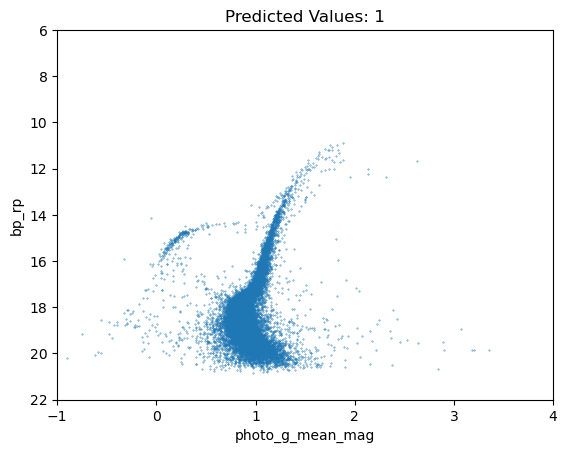

In [132]:
import matplotlib.pyplot as plt
model.eval()
all_preds = []
all_data = []
with torch.no_grad():
    for stars, labels in val_dataloader:
        stars = stars.to(device)
        outputs = model(stars)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_data.extend(stars.cpu().numpy())

# Convert predictions and data to DataFrame
all_data = np.array(all_data).squeeze(1)
all_preds = np.array(all_preds)
test_df = pd.DataFrame(all_data, columns=data.columns[2:-1])
test_df['preds'] = all_preds

# Filter predicted values as 1 and plot
predicted_ones = test_df[test_df['preds'] == 1]
plt.scatter( predicted_ones['bp_rp'],predicted_ones['phot_g_mean_mag'],s = 0.1)
plt.xlabel('photo_g_mean_mag')
plt.ylabel('bp_rp')
plt.ylim(22, 6)
plt.xlim(-1, 4)
plt.title('Predicted Values: 1')
plt.show()

In [138]:
test_acc = 0.0
f1 = 0.0
for i,(stars,labels) in enumerate(val_dataloader,0):
    stars = stars.to(device)
    labels = labels.to(device)
    outputs = model(stars)
    test_acc+=(torch.argmax(outputs,1).flatten() == labels).type(torch.float).mean().item()
    preds = torch.argmax(outputs,1).flatten().cpu().numpy()
    l = labels.cpu().numpy()
    f1 += metrics.f1_score(l,preds)
print("Test Accuracy %.2f | F1 Score %.2f "%(test_acc/i,f1/i))

Test Accuracy 0.92 | F1 Score 0.91 


# Graph Neural Network